# Machine Learning Foundation

## Course 6, Part e: ARMA DEMO

# Introduction

In the previous three lessons, you learned several fundamental time series concepts like stationarity and smoothing. Now we'll build upon that knowledge by digging into yet another important concept called **autocorrelation**.

# Learning Outcomes
You should walk away from this tutorial with:
1. A practical understanding of Autoregressive (AR) models.
1. A practical understanding of Moving Average (MA) models.
1. A basic understanding of the Autocorrelation Function (ACF).
1. A basic understanding of the Partial Autocorrelation Function (PACF).
1. Insight into choosing the order *q* of MA models.
1. Insight into choosing the order *p* of AR models.

# Imports

In [18]:
import sys, os
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sys.path.append(r"IBM_Specialized_Models/Time Series and Survival Analysis")
os.chdir(
    r"C:/Users/cjr21/OneDrive/Documents/IBM_Specialized_Models/Time Series and Survival Analysis"
)
from colorsetup import colors, palette

sns.set_palette(palette)
os.chdir(
    r"C:/Users/cjr21/OneDrive/Documents/IBM_Specialized_Models/Time Series and Survival Analysis/data"
)

One of the key concepts in the quantitative toolbox is that of mean reversion. This process refers to a time series that displays a tendency to revert to its historical mean value. Mathematically, such a (continuous) time series is referred to as an Ornstein-Uhlenbeck process. 

This is in contrast to a random walk (aka Brownian motion), which has no "memory" of where it has been at each particular instance of time. 

The mean-reverting property of a time series can be exploited in order to produce better predictions.

A continuous mean-reverting time series can be represented by an Ornstein-Uhlenbeck stochastic differential equation:

$dx_{t} = θ(μ−x_{t})dt + σdW_{t}$
 
Where: 
- θ is the rate of reversion to the mean, 
- μ is the mean value of the process, 
- σ is the variance of the process and 
- $W_{t}$ is a Wiener Process or Brownian Motion.

In a discrete setting the equation states that the change of the price series in the next time period is proportional to the difference between the mean price and the current price, with the addition of Gaussian noise.

https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing

## Section 2: ARMA

Enter [Autoregressive Integrated Moving Average (ARIMA)](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) modeling. When we have autocorrelation between outcomes and their ancestors, we will see a theme, or relationship in the outcome plot. This relationship can be modeled in its own way, allowing us to predict the future with a confidence level commensurate to the strength of the relationship and the proximity to known values (prediction weakens the further out we go).

- [ARIMA in R](https://www.otexts.org/fpp/8/5)
- [Duke ARIMA Guide](https://people.duke.edu/~rnau/411arim2.htm)
- [Great explanation on MA in practice](http://stats.stackexchange.com/questions/164824/moving-average-ma-process-numerical-intuition)


For second-order stationary (both mean and variance: $\mu_t = \mu$ and $\sigma_t^2 = \sigma^2$ for all $t$) data, autocovariance is expressed as a function only of the time lag $k$:

$$ \gamma_k = E[(x_t-\mu)(x_{t+k} - \mu)] $$
  
Therefore, the autocorrelation function is defined as:

$$ \rho_k = \frac{\gamma_k}{\sigma^2} $$
  
We use the plot of these values at different lags to determine optimal ARIMA parameters. Notice how `phi` changes the process.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/ArTimeSeries.svg/685px-ArTimeSeries.svg.png)
By Tomaschwutz - Own work, CC BY 3.0, https://commons.wikimedia.org/w/index.php?curid=14740378



## Section 3: Autoregressive (AR) Models

**Autocorrelation:** a variable's correlation with itself at different lags.

AR models regress on actual past values 

This is the first order or **AR(1)** formula you should know: $y_t = \beta_0 + \beta_1y_{t-1}+\epsilon_t$

The $\beta$'s are just like those in linear regression and $\epsilon$ is irreducible error.

A second order or **AR(2)** would look like this: $y_t = \beta_0 + \beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t$

The pattern of adding another coefficient and another past term continues to whichever order you choose. Choosing that order called *p* is something we will discuss shortly.

In the meantime, let's walk through a basic autocorrelation example. We'll generate our own data to gain insight into how ar models work

In [5]:
# reproducibility
np.random.seed(123)

# create autocorrelated data
time = np.arange(100)
# Assuming 0 mean
ar1_sample = np.zeros(100)

# Set our first number to a random value with expected mean of 0 and standard deviation of 2.5
ar1_sample[0] += np.random.normal(loc=0, scale=2.5, size=1)[0]

# Set every value thereafter as 0.7 * the last term plus a random error
for t in time[1:]:
    ar1_sample[t] = (0.7 * ar1_sample[t - 1]) + np.random.normal(
        loc=0, scale=2.5, size=1
    )[0]

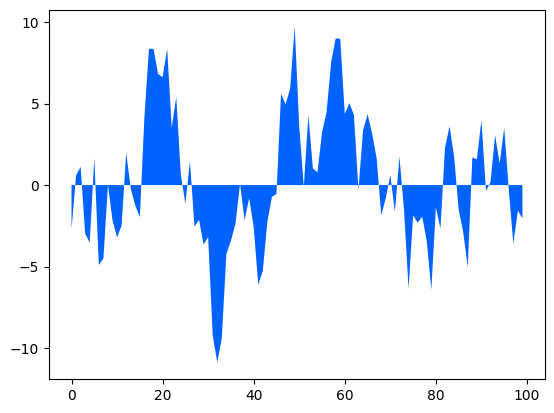

In [6]:
plt.fill_between(time, ar1_sample)

Here we create prediction for generated data to show we came up with a model that is approximately ar(1) with phi $\approx$ 0.7

In [20]:
# using ARMA model from statsmodel package
model = ARIMA(ar1_sample, order=(1, 0, 0)).fit()
model.params

array([0.13538633, 0.73323115, 7.89468564])

In [22]:
# create autocorrelated data
np.random.seed(112)
# Mean is again 0
ar2_sample = np.zeros(100)
# Set first two values to random values with expected mean of 0 and standard deviation of 2.5
ar2_sample[0:2] += np.random.normal(loc=0, scale=2.5, size=2)
# Set future values as 0.3 times the prior value and 0.3 times value two prior
for t in time[2:]:
    ar2_sample[t] = (
        (0.3 * ar2_sample[t - 1])
        + (0.3 * ar2_sample[t - 2])
        + np.random.normal(loc=0, scale=2.5, size=1)[0]
    )

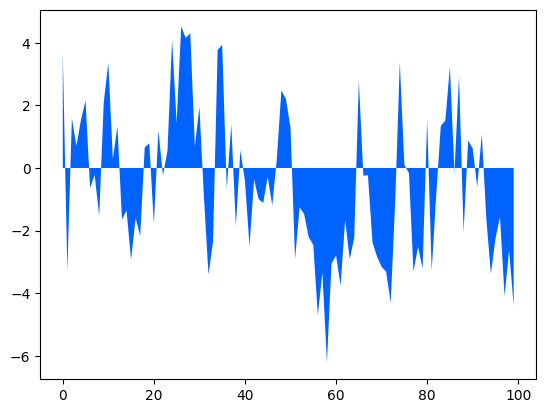

In [23]:
plt.fill_between(time, ar2_sample)

In [24]:
# Again running statsmodel ARMA to predict parameters for generated data
model = ARIMA(ar2_sample, order=(2, 0, 0)).fit()
model.params

array([-0.53966327,  0.35251402,  0.23334235,  4.23778684])

In [25]:
# Below is function to help in generating different series
from statsmodels.tsa.arima_process import arma_generate_sample

arparams = np.array([0.3, 0.3])
maparams = np.array([0])
ar = np.r_[1, -arparams]  # add zero-lag and negate, np.r_ is simply making it one array
ma = np.r_[1, maparams]  # add zero-lag
y = arma_generate_sample(ar, ma, 100)

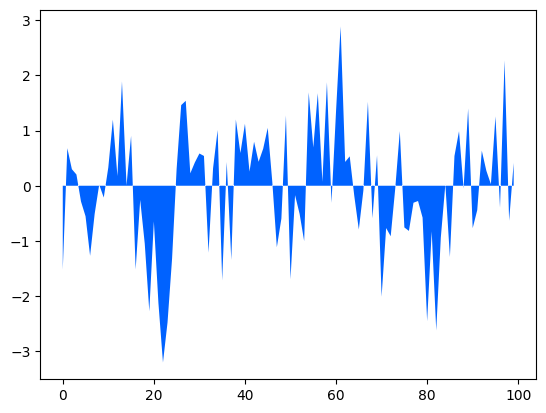

In [26]:
plt.fill_between(time, y)

In [29]:
# Again running statsmodel ARMA to predict parameters for generated data
model = ARIMA(y, order=(2, 0, 0)).fit()
model.params

array([-0.06184517,  0.17136503,  0.31734628,  1.08004523])

Notice that outcomes of same model can be very different given random nature of model and fact that this is emant to predict mean reversion

## Section 4: Moving Average(MA) models


### MA Model Specifics
A MA model is defined by this equation: $y_t=c+e_t+θ_1e_{t−1}+θ_2e_{t−2}+⋯+θ_qe_{t−q}$ where $e_t$ is white noise. The value $c$ is a constant value and the $\theta$'s are coefficients, not unlike those found in linear regression.

### MA Models != Moving Average Smoothing
An important distinction is that a moving average model is not the same thing as moving average smoothing. What we did in previous lessons was smoothing. It has important properties already discussed. However, we turn our attention to moving average models, which are a completely different beast.

Moving average smoothing is useful for estimating trend and seasonality of past data. MA models, on the other hand, are a useful forecasting model that regresses on past forecast errors in order to forecast future values. It is easy to lump the two techniques together, but they serve very different functions. 
Thus, a moving-average model is conceptually a linear regression of the current value of the series against current and previous (unobserved) white noise error terms or random shocks. The random shocks at each point are assumed to be mutually independent and to come from the same distribution, typically a normal distribution, with location at zero and constant scale.

### Interpretation
The moving-average model is essentially a finite impulse response filter applied to white noise, with some additional interpretation placed on it. 

The role of the random shocks in the MA model differs from their role in the autoregressive (AR) model in two ways.
- First, they are propagated to future values of the time series directly: for example, 
$\varepsilon _{t-1}$ appears directly on the right side of the equation for $X_{t}$. In contrast, in an AR model $\varepsilon _{t-1}$ does not appear on the right side of the $X_{t}$ equation, but it does appear on the right side of the $X_{t-1}$ equation, and $X_{t-1}$ appears on the right side of the $X_{t}$ equation, giving only an indirect effect of $\varepsilon _{t-1}$ on $X_{t}$. 
- Second, in the MA model a shock affects X values only for the current period and q periods into the future; in contrast, in the AR model a shock affects X values infinitely far into the future, because $\varepsilon _{t}$ affects $X_{t}$, which affects $X_{t+1}$, etc.

https://en.wikipedia.org/wiki/Moving-average_model

We'll generate our own data so we know the generative process for an MA series. 

In [11]:
# reproducibility
np.random.seed(12)

# create autocorrelated data
time = np.arange(100)
# mean 0
ma1_sample = np.zeros(100)
# create vector of random normally distributed errors
error = np.random.normal(loc=0, scale=2.5, size=100)
# set first value to one of the random errors
ma1_sample[0] += error[0]

# set future values to 0.4 times error of prior value plus the current error term
for t in time[1:]:
    ma1_sample[t] = (0.4 * error[t - 1]) + error[t]

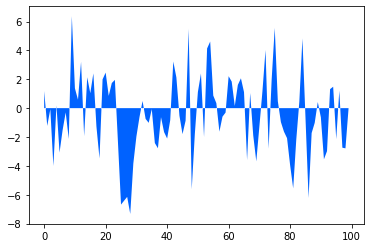

In [12]:
plt.fill_between(time, ma1_sample)

In [13]:
# find model params for generated sample
model = sm.tsa.ARMA(ma1_sample, (0, 1)).fit(trend="nc", disp=0)
model.params

array([0.34274651])

In [14]:
# reproducibility
np.random.seed(123)

# create autocorrelated data
time = np.arange(100)
ma2_sample = np.zeros(100)
error = np.random.normal(loc=0, scale=2.5, size=100)
ma2_sample[0:2] = error[0:2]
# regress future values on linear functino of prior two errors plus current error
for t in time[2:]:
    ma2_sample[t] = (0.4 * error[t - 1]) + (-0.4 * error[t - 2]) + error[t]

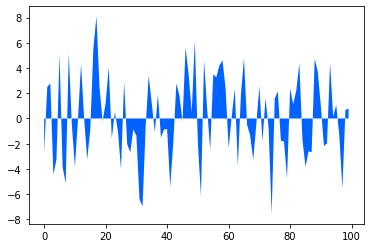

In [15]:
plt.fill_between(time, ma2_sample)

In [16]:
# find model params for generated sample
model = sm.tsa.ARMA(ma2_sample, (0, 2)).fit(trend="nc", disp=0)
model.params

array([ 0.45947617, -0.4130215 ])

In [17]:
# Below is function to help in generating different series
np.random.seed(123)
arparams = np.array([0])
maparams = np.array([0.4, -0.4])
ar = np.r_[1, -arparams]  # add zero-lag and negate, np.r_ is simply making it one array
ma = np.r_[1, maparams]  # add zero-lag
y = arma_generate_sample(ar, ma, 100)

In [18]:
# Just to show we came up with a model that is approximately ar(1) with phi = 0.7
# We will get back to modeling

model = sm.tsa.ARMA(y, (0, 2)).fit(trend="nc", disp=0)
model.params

array([ 0.45956844, -0.41054157])

Some things to note:
1. AR models propagate shocks infinitely
1. If a process depends on previous values of itself then it is an AR process. If it depends on previous errors than it is an MA process.
1. AR processes will exhibit exponential decay in ACF and a cut-off in PACF

### Moving Average Models (This is NOT a Simple/Weighted/Exponential Moving Average)

Some things to note:
1. MA models do not propagate shocks infinitely; they die after `q` lags
1. If a process depends on previous values of itself, then it is an AR process. If it depends on previous errors, then it is an MA process.
1. MA processes will exhibit exponential decay in PACF and a cut-off in ACF

## Section 5: The Autocorrelation Function (ACF)
There's a crucial question we need to answer: How do you choose the orders (p and q) for a time series

In order to answer that question, we need to understand the Autocorrelation Function (ACF). 

Let's start by showing an example ACF plot for our different simulated series.

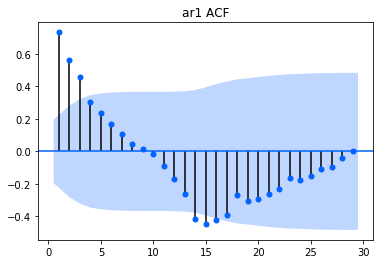

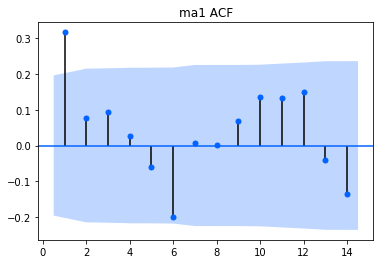

In [19]:
fig = sm.tsa.graphics.plot_acf(
    ar1_sample, lags=range(1, 30), alpha=0.05, title="ar1 ACF"
)
fig = sm.tsa.graphics.plot_acf(
    ma1_sample, lags=range(1, 15), alpha=0.05, title="ma1 ACF"
)

An explanation is in order. First, the blue region represents a confidence interval. Alpha in this case was set to 0.05 (95% confidence interval). This can be set to whatever float value you require. See the **plot_acf** function for details. 

The stems represent lagged correlation values. In other words, a lag of 1 will show correlation with the prior endogenous value. A lag of 2 shows correlation to the value 2 prior and so on. Remember that we're regressing on past forecast values; that's the correlation we're inspecting here. 

Correlations outside of the confidence interval are statistically significant whereas the others are not. 

Note that if lag 1 shows strong autocorrelation, lag 2 will show strong autocorrelation as well since lag 1 is correlated with lag 2 and lag 2 with lag 3. That is why you see the ar1 model having the slowly decaying correlation.

If we think about the functions, we note that the autocorrelation will propogate for AR(1) models:

- $y_t = \beta_0 + \beta_1y_{t-1}+\epsilon_t$
- $y_{t-1} = \beta_0 + \beta_1y_{t-2}+\epsilon_{t-1}$
- $y_{t} = \beta_0 + \beta_0 + \beta_1y_{t-2}+\epsilon_{t-1} +\epsilon_{t}$

The past errors will propogate into the future leading to the slowly decaying plot we just mentioned

For MA(1) models: 

- $y_t = y_t=\beta_0+θ_1e_{t-1}+\epsilon_t$

Only the prior error has an effect on future errors.

So an easy way to identify an ar(1) models or ma(1) model is to look to see if the correlation from one effects the next.

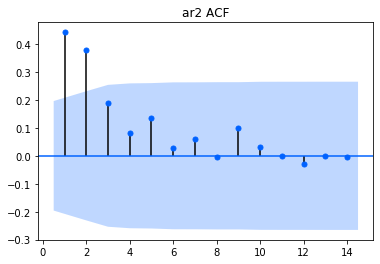

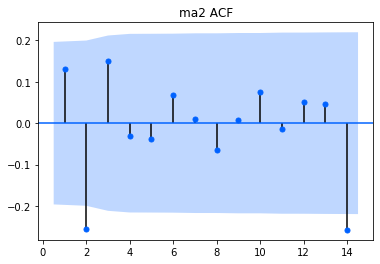

In [20]:
fig = sm.tsa.graphics.plot_acf(
    ar2_sample, lags=range(1, 15), alpha=0.05, title="ar2 ACF"
)
fig = sm.tsa.graphics.plot_acf(
    ma2_sample, lags=range(1, 15), alpha=0.05, title="ma2 ACF"
)

Similar story should hold up for ACF for AR(2) and MA(2). Ideally, the ma(1) would be significant, but with simulated data it will not always be perfect


## Section 6: The Partial Autocorrelation Function (PACF)

Choosing the order *p* of the AR model is important. Thankfully, there's a useful plot called the Partial Autocorrelation Function plot that can help us with that task. 

Let's look at an example.

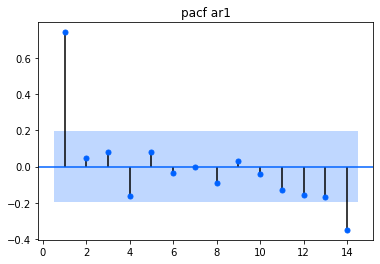

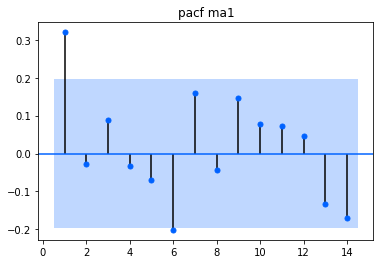

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = sm.tsa.graphics.plot_pacf(
    ar1_sample, lags=range(1, 15), alpha=0.05, title="pacf ar1"
)
fig = sm.tsa.graphics.plot_pacf(
    ma1_sample, lags=range(1, 15), alpha=0.05, title="pacf ma1"
)

The *partial autocorrelation* at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. 

This makes choosing AR(1) models much easier.

First off, the blue region once again is the 95% confidence interval. 

The ACF is a way to measure the linear relationship between a current observation and observations at previous time periods. It turns out that often we are really only interested in the relationship between the current observation and a past value determined by a lag value. We often don't care about the relationship of values between the two, so we transform them to obtain the PACF. 

The PACF is a useful tool for identifying the order of the AR model.

For MA(1) model we should see that it slowly decays towards 0.

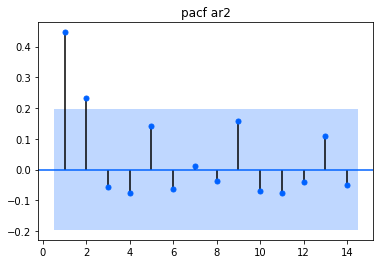

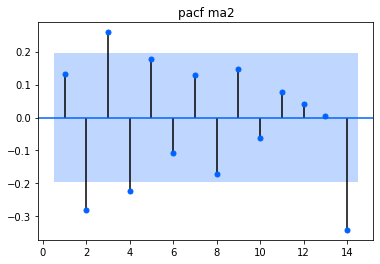

In [22]:
fig = sm.tsa.graphics.plot_pacf(
    ar2_sample, lags=range(1, 15), alpha=0.05, title="pacf ar2"
)
fig = sm.tsa.graphics.plot_pacf(
    ma2_sample, lags=range(1, 15), alpha=0.05, title="pacf ma2"
)

Similar story should hold up for PACF for AR(2).


## Exercise
You have been provided two datasets: 
1. **auto_1.csv**
2. **auto_2.csv**

Your task is to leverage what you've learned in this and previous courses. 

More specifically, you will do the following:
1. Read in **auto_1.csv** and **auto_2.csv**.
2. Create a time variable called **mytime** that starts at 0 and is as long as both datasets.
3. Generate fill between plots of auto_1 and auto_2.
4. Determine the order of p and q.
5. Fit model given chosen p and q. Feel free to play with fit of other models

#### 1. Get Data

In [23]:
# get data
path_to_file = "./"
auto_1 = pd.read_csv(path_to_file + "auto_1.csv")
auto_2 = pd.read_csv(path_to_file + "auto_2.csv")

#### 2. Create mytime 

In [24]:
# time component
mytime = np.arange(len(auto_1))

In [25]:
auto_1.values.shape

(100, 1)

In [26]:
auto_1 = auto_1.values.reshape(-1)
auto_2 = auto_2.values.reshape(-1)

#### 3. Fill between plots

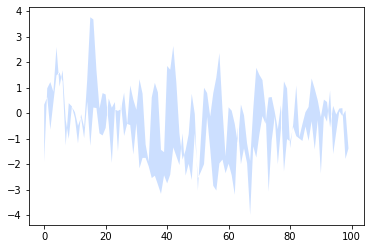

In [27]:
plt.fill_between(mytime, auto_1, auto_2, alpha=0.2)

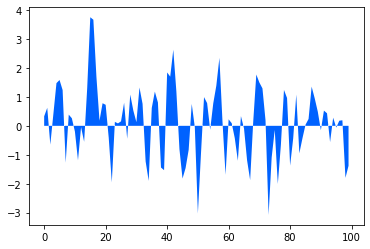

In [28]:
plt.fill_between(mytime, auto_2)

#### 4. Determine Order (p & q) 

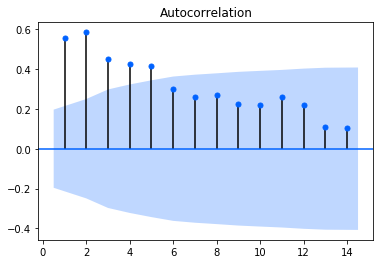

In [29]:
fig1 = sm.tsa.graphics.plot_acf(auto_1, lags=range(1, 15), alpha=0.05)

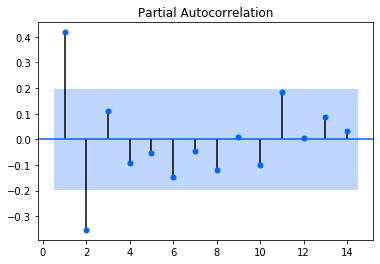

In [30]:
fig2 = sm.tsa.graphics.plot_pacf(auto_2, lags=range(1, 15), alpha=0.05)

For auto_1, order p is clearly 2.

For auto_2, looks like order of q is 1. 

#### 5. Estimate parameters of model with given choice of p and q

In [31]:
model = sm.tsa.ARMA(auto_1, (2, 0)).fit(trend="nc", disp=0)
model.params

array([0.37346287, 0.48047133])

In [32]:
model = sm.tsa.ARMA(auto_2, (0, 1)).fit(trend="nc", disp=0)
model.params

array([0.62846612])

---

# Summary

In this notebook, we have covered: 
1. Moving Average (MA) models.
2. The Autocorrelation Function (ACF).
3. Choosing order *q*.
4. Autoregressive (AR) models.
5. The Partial Autocorrelation Function (PACF).
6. Choosing order *p*. 

---
### Machine Learning Foundation (C) 2020 IBM Corporation